In [3]:
import pickle
import os
import math
import pywt
import numpy as np
import pandas as pd
import datetime as dt
import mysql.connector as c
import matplotlib.pyplot as plt

from scipy import signal
from scipy.interpolate import interp1d
from scipy.stats import variation, linregress

# 1. 特征提取

## 1.1 加载数据

In [6]:
TIME_FORMAT = "%Y-%m-%d %H:%M:%S"
START_TIMESTAMP = dt.datetime.strptime("2016-12-04 00:00:00", TIME_FORMAT).timestamp()
PICKLE_LOADED_FROM_DB = 'p_raw_series_dict.pickle'
PICKLE_FEATURES = 'p_label_feature.pickle'

conn = c.connect(user='root', password='ictwsn', host='10.22.0.77', database='curiosity_20161204')
label_df = pd.read_sql("select * from manual_label_t where label!=''", conn)
label_dict = {(val['feed_id'], val['stream_id']): val['label'] for _, val in label_df.iterrows()}

if os.path.isfile(PICKLE_LOADED_FROM_DB):
    series_dict = pickle.load(open(PICKLE_LOADED_FROM_DB, 'rb'))
else:
    series_dict = dict()  # 每个(feedid, datastreamid)对应一个(time_at, val)的list
    cursor = conn.cursor()
    for f_id, s_id in labeled:
        cursor.execute("""
            select feedid, datastreamid, time_at, val from datapoint_t
            where feedid=%s and datastreamid=%s
        """, (f_id, s_id))
        series_dict[(f_id, s_id)] = [(time_at, val) for _, _, time_at, val in cursor.fetchall()]
        
    pickle.dump(series_dict, open(PICKLE_LOADED_FROM_DB, 'wb'))

## 1.2 计算特征

In [10]:
len_of_2days = 1440 * 2
f_dict = dict()
black_list = []

for fd_tuple, series in series_dict.items():
    feature = []
    samples = []

    # 对数据进行插值
    tlist = [(series[i][0].timestamp() - START_TIMESTAMP)/60 for i in range(len(series))]
    vlist = [series[i][1] for i in range(len(series))]
    tlist = [0] + tlist + [len_of_2days]
    vlist = [vlist[0]] + vlist + [vlist[-1]]

    # print(fd_tuple)
    try:
        interp_f = interp1d(tlist, vlist)
        interp_f = interp1d(tlist, vlist)
        for cur_time in range(0, len_of_2days, 10):
            v = interp_f(cur_time)  # 每十分钟进行一次采样
            samples.append(v/abs(v)*(200 + math.log(abs(v - 200 + 1))) if abs(v) > 200 else v)
    except ValueError:
        print('Error detected!')
        black_list.append(fd_tuple)
        continue

    # 常规参数
    sample_np = np.array(samples)
    s_ave = np.average(sample_np)
    feature.append(s_ave)
    feature.append(variation(sample_np))
    feature.append(np.min(sample_np))
    feature.append(np.max(sample_np))

    # 小波系数
    w_coeff = pywt.wavedec(samples, 'haar', level=5)
    feature.append(np.linalg.norm(w_coeff[0]))
    feature.append(np.linalg.norm(w_coeff[1]))
    feature.append(np.linalg.norm(w_coeff[2]))
    feature.append(np.linalg.norm(w_coeff[3]))
    feature.append(np.linalg.norm(w_coeff[4]))

    # 对于均值的zero cross
    zc = [i for i in range(1, sample_np.size-1) if (sample_np[i] - s_ave)*(sample_np[i-1] - s_ave) > 0]
    feature.append(len(zc))

    # 一阶回归之后的整体趋势
    slope, intercept, r_value, p_value, std_err = linregress(sample_np.tolist(), list(range(len(sample_np))))
    feature.append(slope)
    feature.append(intercept)
    feature.append(r_value)
    feature.append(p_value)
    feature.append(std_err)

    # 检查数据有效性
    is_invalid = False
    for f in feature:
        if math.isnan(f) or math.isinf(f):
            is_invalid = True
            break
    if not is_invalid:
        f_dict[fd_tuple] = feature

l_swap_dict = dict()
for fs_tuple, f_list in f_dict.items():
    l_swap_dict[fs_tuple] = label_dict[fs_tuple]

result = {'label_dict': l_swap_dict, 'feature_dict': f_dict}
pickle.dump(result, open(PICKLE_FEATURES, 'wb'))
print('Length of label_dict = ' + str(len(l_swap_dict)))
print('Length of feature_dict = ' + str(len(f_dict)))

/usr/local/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:95: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:976: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


Error detected!
Error detected!
Error detected!
Error detected!
Error detected!
Error detected!
Error detected!
Error detected!
Error detected!
Error detected!
Error detected!
Error detected!
Error detected!
Length of label_dict = 1021
Length of feature_dict = 1021


# 2. 分类方法

## 2.1 顺序打乱

In [16]:
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import MultipleLocator
from sklearn.ensemble import RandomForestClassifier
from random import shuffle
import matplotlib.pyplot as plt


raw_dict = pickle.load(open('p_label_feature.pickle', 'rb'))
label_dict = raw_dict['label_dict']
feature_dict = raw_dict['feature_dict']

n_per_fold = int(len(label_dict)/n_fold)
all_tuple = [fs_tuple for fs_tuple, v in label_dict.items()]
all_label = [label_dict[fs_tuple] for fs_tuple, v in label_dict.items()]
all_feature = [feature_dict[fs_tuple] for fs_tuple in all_tuple]

bundle = [(all_tuple[i], all_label[i], all_feature[i]) for i,_ in enumerate(all_tuple)]
shuffle(bundle)
for i, _ in enumerate(bundle):
    all_tuple[i] = bundle[i][0]
    all_label[i] = bundle[i][1]
    all_feature[i] = bundle[i][2]


## 2.2 交叉验证

In [17]:
n_fold = 10

for i in range(n_fold):
    
    test_tuple = all_tuple[i*n_per_fold:(i+1)*n_per_fold]
    test_label = all_label[i*n_per_fold:(i+1)*n_per_fold]
    test_feature = all_feature[i*n_per_fold:(i+1)*n_per_fold]
    
    train_tuple = all_tuple[0:i*n_per_fold] + all_tuple[(i+1)*n_per_fold+1:-1]
    train_label = all_label[0:i*n_per_fold] + all_label[(i+1)*n_per_fold+1:-1]
    train_feature = all_feature[0:i*n_per_fold] + all_feature[(i+1)*n_per_fold+1:-1]
    
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(train_feature, train_label)
    preds = rfc.predict(test_feature)

    acc_list = [p for i,p in enumerate(preds) if p==test_label[i]]
    print('Acc = ' + str(100.0*len(acc_list)/len(preds)))

Acc = 51.96078431372549
Acc = 60.78431372549019
Acc = 56.86274509803921
Acc = 55.88235294117647
Acc = 58.8235294117647
Acc = 65.68627450980392
Acc = 58.8235294117647
Acc = 62.745098039215684
Acc = 63.72549019607843
Acc = 63.72549019607843


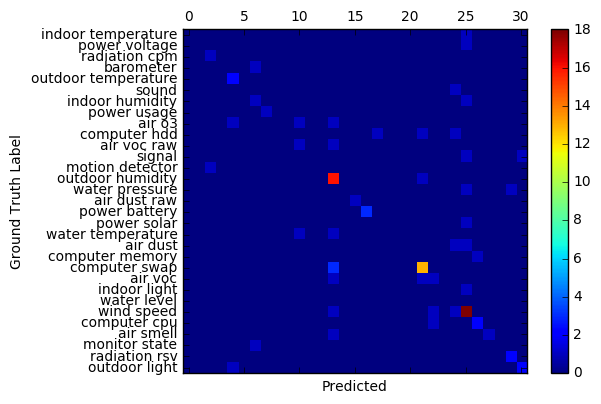

In [19]:
label_names = []
for L in train_label + test_label:
    if L not in label_names:
        label_names.append(L)

cm = confusion_matrix(test_label, preds)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm.tolist())
fig.colorbar(cax)
# ax.set_xticklabels([''] + label_names, rotation=90)
ax.set_yticklabels([''] + label_names)
# ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('Ground Truth Label')
plt.show()

# 3. 分类优化

Random forest可以得到不同分类的概率，通过结合组别信息，可以得到更为精确的分类结果。
一个应用包含多种不同的传感器，故可以使用其中包含的传感器配比信息区别不同应用。
所以设计了以下算法进行优化：
1. 使用k-means对不同应用进行聚类，表现在数据集中则是对feedid进行归类
2. 对于同一组应用中的不同传感器，可以计算得到每个传感器属于不同类型的综合打分。

In [1]:
import pickle
import networkx as nx
import numpy as np
from random import shuffle
from sklearn.ensemble import RandomForestClassifier


def kmeans(features, n_mu=10, max_iter=10):
    cluster_label = [0] * len(features)
    mu_list = np.random.rand(n_mu, len(features[0]))  # 每个聚类的中心K*27
    mu_list /= np.matrix(np.sum(mu_list, axis=1)).T

    for iter_times in range(max_iter):
        for i, x in enumerate(features):
            distance = np.asarray([sum((mu - x) ** 2) for mu in mu_list])
            cluster_label[i] = distance.argmin()

        mu_count = [0] * n_mu
        mu_sum = np.zeros((n_mu, len(features[0])))

        for i, x in enumerate(features):
            mu_sum[cluster_label[i]] += x
            mu_count[cluster_label[i]] += 1

        for idx, mu_feature in enumerate(mu_list):
            if mu_count[idx] != 0:
                mu_list[idx] = mu_sum[idx] / mu_count[idx]
    return cluster_label, mu_list


def adjust_sensor_choice(sensor_proba, type_target, portion_lambda=0.01, rounding_scale=10):
    n_sensors = len(sensor_proba)
    graph_edge = []
    for idx, p_si in enumerate(sensor_proba):
        graph_edge.append((0, 1 + idx, {'capacity': 1, 'weight': 0}))
        for idx_t, _ in enumerate(type_target):
            if p_si[idx_t] != 0:
                st = {'capacity': 1, 'weight': 1.0 / p_si[idx_t]}
                graph_edge.append((1 + idx, 1 + idx_t + n_sensors, st))

    for idx_t, t in enumerate(type_target):
        s = sum(type_target)
        if t != 0:
            st = {'capacity': n_sensors, 'weight': 1.0 * portion_lambda * s / t}
            graph_edge.append((1 + n_sensors + idx_t, 1 + n_sensors + len(type_target), st))

    # 当weight和capacity为浮点数时方法失效，所以将权重进行rounding
    min_weight = min([e[2]['weight'] for e in graph_edge if e[2]['weight'] > 0])
    ratio = rounding_scale / min_weight
    for e in graph_edge:
        e[2]['weight'] = int(ratio * e[2]['weight'])

    graph = nx.DiGraph()
    graph.add_edges_from(graph_edge)
    flow_dict = nx.max_flow_min_cost(graph, 0, 1 + n_sensors + len(type_target))

    choice = []
    for node_idx in range(n_sensors):
        if 1 + node_idx in flow_dict:
            alist = [to for to, c in flow_dict[1 + node_idx].items() if c == 1]
            choice.append(np.argmax(sensor_proba[node_idx]) if len(alist) == 0 else alist[0] - n_sensors - 1)
    return choice


def result_refine(tuples, sensor_p, choices, max_iter=3):
    """
    输入的tuples和其他对应的位全部是乱序的
    返回sensor类型的选择状态sensor_choice
    """
    feedid = [tuples[i][0] for i, _ in enumerate(tuples)]
    n_types = len(sensor_p[0])

    group_p = []  # 存储每个组的概率
    group_id = []  # 存储每个组的id
    group_cnt_dict = dict()
    for i in range(len(tuples)):
        if tuples[i][0] not in group_cnt_dict:
            group_cnt_dict[tuples[i][0]] = [0]*n_types
        cnt = group_cnt_dict[tuples[i][0]]
        cnt[choices[i]] += 1

    for k, v in group_cnt_dict.items():
        group_id.append(k)
        group_p.append(np.asarray(v) / np.sum(v))

    print('group_id, group_p prepared!')

    for run_once in range(max_iter):
        cluster_label, mu_list = kmeans(group_p, max_iter=10)  # 执行一次聚类
        print('k-means done!')

        group_dict = dict()  # 找到每个组对应的sensor的id
        for idx, f in enumerate(feedid):
            if f not in group_dict:
                group_dict[f] = []
            group_dict[f].append(idx)

        for idx, cluster in enumerate(cluster_label):
            sensor_proba = []  #当前组每个节点的分布 n*len(features[0])
            sensor_id_list = []
            for sensor_idx in group_dict[group_id[idx]]:
                sensor_proba.append(sensor_p[sensor_idx])
                sensor_id_list.append(sensor_idx)

            choice = adjust_sensor_choice(sensor_proba, mu_list[cluster])
            for inner_idx, sensor_idx in enumerate(sensor_id_list):
                choices[sensor_idx] = choice[inner_idx]

        print('Adjust done!')

    return choices

使用单次的数据进行测试：
1. 使用“十一”划分，并使用random forest计算出前1/10的每个数据条目的概率
2. 将概率和训练集中的进行拼接，all_proba，即每个条目对应的概率
3. 调用result_refine方法重新计算每个条目的类型sensor_type

进行整体的交叉验证

In [2]:
def compute_acc(y, y_test):
    acc = len([c_y for idx_y, c_y in enumerate(y) if c_y == y_test[idx_y]])
    return 1.0 * acc / len(y)


raw_dict = pickle.load(open('p_label_feature.pickle', 'rb'))
label_dict = raw_dict['label_dict']
feature_dict = raw_dict['feature_dict']

n_per_fold = int(len(label_dict)/n_fold)
all_tuple = [fs_tuple for fs_tuple, v in label_dict.items()]
all_label = [label_dict[fs_tuple] for fs_tuple in all_tuple]
all_feature = [feature_dict[fs_tuple] for fs_tuple in all_tuple]

bundle = [(all_tuple[i], all_label[i], all_feature[i]) for i in range(len(all_tuple))]
shuffle(bundle)
for i in range(len(bundle)):
    all_tuple[i] = bundle[i][0]
    all_label[i] = bundle[i][1]
    all_feature[i] = bundle[i][2]

test_tuple = all_tuple[0:n_per_fold]
test_label = all_label[0:n_per_fold]
test_feature = all_feature[0:n_per_fold]
train_tuple = all_tuple[n_per_fold:]
train_label = all_label[n_per_fold:]
train_feature = all_feature[n_per_fold:]

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_feature, train_label)

index2name = rfc.classes_  # 概率对应位置的标签
name2index = {cls: idx for idx, cls in enumerate(rfc.classes_)}
test_proba = rfc.predict_proba(test_feature).tolist()

for i in range(len(train_tuple)):
    arr = [0.0] * len(index2name)
    arr[name2index[train_label[i]]] = 1.0
    test_proba.append(arr)

sensor_choice = [np.argmax(p) for p in test_proba]
y_before = [index2name[idx] for idx in sensor_choice]
print(compute_acc(all_label, y_before))
sensor_choice = result_refine(all_tuple, test_proba, sensor_choice)  # 结果优化
y_after = [index2name[idx] for idx in sensor_choice]
print(compute_acc(all_label, y_after))


0.9549461312438785
group_id, group_p prepared!
k-means done!
Adjust done!
k-means done!
Adjust done!
k-means done!
Adjust done!
0.9559255631733594


In [6]:
raw_dict = pickle.load(open('p_label_feature.pickle', 'rb'))
label_dict = raw_dict['label_dict']
feature_dict = raw_dict['feature_dict']

n_per_fold = int(len(label_dict)/n_fold)
all_tuple = [fs_tuple for fs_tuple, v in label_dict.items()]
all_label = [label_dict[fs_tuple] for fs_tuple in all_tuple]
all_feature = [feature_dict[fs_tuple] for fs_tuple in all_tuple]

bundle = [(all_tuple[i], all_label[i], all_feature[i]) for i in range(len(all_tuple))]
shuffle(bundle)
for i in range(len(bundle)):
    all_tuple[i] = bundle[i][0]
    all_label[i] = bundle[i][1]
    all_feature[i] = bundle[i][2]

n_fold = 10
for i in range(n_fold):
    test_tuple = all_tuple[i * n_per_fold:(i + 1) * n_per_fold]
    test_label = all_label[i * n_per_fold:(i + 1) * n_per_fold]
    test_feature = all_feature[i * n_per_fold:(i + 1) * n_per_fold]
    train_tuple = all_tuple[0:i * n_per_fold] + all_tuple[(i + 1) * n_per_fold:]
    train_label = all_label[0:i * n_per_fold] + all_label[(i + 1) * n_per_fold:]
    train_feature = all_feature[0:i * n_per_fold] + all_feature[(i + 1) * n_per_fold:]

    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(train_feature, train_label)

    index2name = rfc.classes_  # 概率对应位置的标签
    name2index = {cls: idx for idx, cls in enumerate(rfc.classes_)}
    test_proba = []
    result_proba = rfc.predict_proba(test_feature).tolist()

    for ii in range(i*n_per_fold):
        arr = [0.0] * len(index2name)
        arr[name2index[train_label[ii]]] = 1.0
        test_proba.append(arr)

    test_proba += result_proba

    for ii in range(i*n_per_fold, len(train_tuple)):
        arr = [0.0] * len(index2name)
        arr[name2index[train_label[ii]]] = 1.0
        test_proba.append(arr)

    sensor_choice = [np.argmax(p) for p in test_proba]
    y_before = [index2name[idx] for idx in sensor_choice]
    print(compute_acc(all_label, y_before))
    sensor_choice = result_refine(all_tuple, test_proba, sensor_choice)  # 结果优化
    y_after = [index2name[idx] for idx in sensor_choice]
    print(compute_acc(all_label, y_after))


0.9539666993143977
group_id, group_p prepared!
k-means done!
Adjust done!
k-means done!
Adjust done!
k-means done!
Adjust done!
0.9539666993143977
0.9569049951028403
group_id, group_p prepared!
k-means done!
Adjust done!
k-means done!
Adjust done!
k-means done!
Adjust done!
0.9569049951028403
0.9637610186092067
group_id, group_p prepared!
k-means done!
Adjust done!
k-means done!
Adjust done!
k-means done!
Adjust done!
0.9657198824681684
0.9529872673849168
group_id, group_p prepared!
k-means done!
Adjust done!
k-means done!
Adjust done!
k-means done!
Adjust done!
0.9559255631733594
0.9647404505386875
group_id, group_p prepared!
k-means done!
Adjust done!
k-means done!
Adjust done!
k-means done!
Adjust done!
0.9676787463271302
0.960822722820764
group_id, group_p prepared!
k-means done!
Adjust done!
k-means done!
Adjust done!
k-means done!
Adjust done!
0.9647404505386875
0.9569049951028403
group_id, group_p prepared!
k-means done!
Adjust done!
k-means done!
Adjust done!
k-means done!
Adju